In [1]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics, tree
from imblearn.under_sampling import RandomUnderSampler
from shap import plots, Explanation, KernelExplainer
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle
import shap
from utils import *

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features),
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_dict, usecols=selected_features)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783531 entries, 0 to 783530
Data columns (total 81 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   flow_duration             783531 non-null  float64
 1   fwd_pkts_tot              783531 non-null  uint64 
 2   bwd_pkts_tot              783531 non-null  uint64 
 3   fwd_data_pkts_tot         783531 non-null  uint64 
 4   bwd_data_pkts_tot         783531 non-null  uint64 
 5   fwd_pkts_per_sec          783531 non-null  float64
 6   bwd_pkts_per_sec          783531 non-null  float64
 7   flow_pkts_per_sec         783531 non-null  float64
 8   down_up_ratio             783531 non-null  float32
 9   fwd_header_size_tot       783531 non-null  uint64 
 10  fwd_header_size_min       783531 non-null  uint8  
 11  fwd_header_size_max       783531 non-null  uint8  
 12  bwd_header_size_tot       783531 non-null  uint64 
 13  bwd_header_size_min       783531 non-null  u

In [4]:
ds.describe()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000
mean,7.930232,15.141476,15.202140,6.076205,11.985713,3.475753e+03,2.813504e+03,6.284778e+03,1.975985,5.221322e+02,23.148409,28.325925,4.665602e+02,18.626142,22.381593,0.778524,1.156447,0.418391,5.386756,8.314095,28.377589,0.001020,0.000008,0.001668,0.000037,17.793925,193.943558,1.685628e+03,1.054549e+02,54.541936,22.216197,1167.560257,1.975559e+04,5.381859e+02,3.519654e+02,17.805741,1178.124581,2.144121e+04,4.416836e+02,2.990518e+02,8.931155e+05,5.733389e+06,8.904876e+06,1.332912e+06,1.162227e+06,2.537420e+04,4.618173e+06,6.764059e+06,4.246261e+05,1.293048e+06,8.930607e+05,6.085861e+06,1.011627e+07,1.260414e+06,8.197949e+05,8.433863e+04,10.925990,11.081897,1159.948376,1.210176e+04,9.029155e+01,4.742144e+03,0.043071,1.864668,6.219484e+03,4.148455e+06,8.041311e+05,1.059131e+06,1.148116e+06,8.946945e+05,1.179072e+05,4.571039e+06,5.764442e+06,8.678673e+06,5.109868e+06,6.037600e+05,25885.029520,26880.533083,7417.383553
std,97.220072,390.717612,395.026085,62.401492,393.515497,1.696581e+05,1.579508e+05,3.246767e+05,31.937681,1.484319e+04,12.629693,15.981276,1.259048e+04,12.781371,16.568396,0.999198,1.029890,0.812277,62.129340,145.891623,785.296047,0.032707,0.002767,0.048602,0.006490,32.828224,300.906381,6.378143e+04,3.639657e+03,351.378688,43.025812,2464.742493,3.385688e+05,1.639081e+04,2.860092e+03,32.883272,2464.226347,3.469619e+05,1.280389e+04,4.456432e+03,6.836720e+07,2.356495e+08,2.966493e+08,9.935204e+07,6.019453e+07,1.451423e+06,2.256559e+08,1.885185e+08,2.769771e+07,1.059583e+08,6.836746e+07,3.022425e+08,7.036060e+08,1.011819e+08,3.227715e+07,5.690312e+06,73.305702,80.394173,14522.031819,1.

In [5]:
ds.columns

Index(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd

We can see from this graph that we don't have highly correlated features.

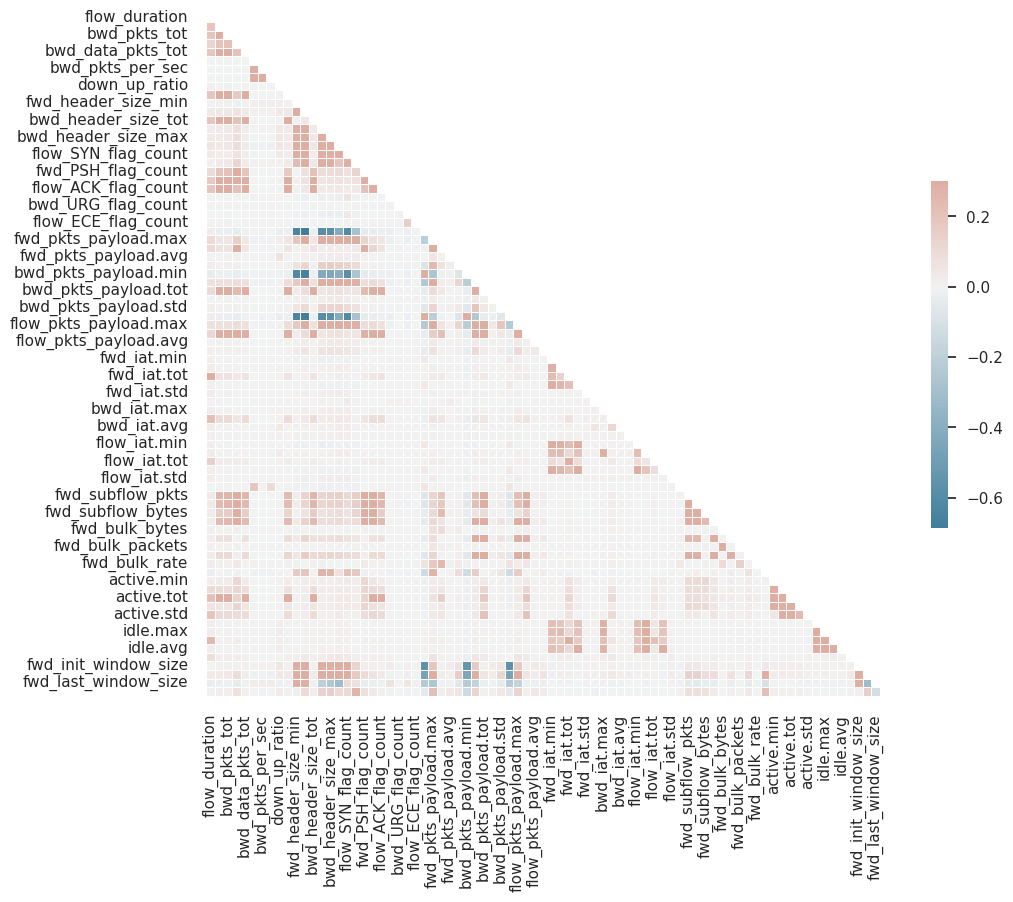

In [6]:

show_corr_matrix(ds)

In [7]:
compute_ratio(ds)

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [58]:
params = {
    'n_estimators': 64,
    'random_state': 0
}

In [59]:
abc = AdaBoostClassifier(**params)
pv = DataPreprocessingAndValidation(ds, 7988, 5, AdaBoostClassifier, params)

In [60]:
X_res, y_res = pv.get_undersampled_ds()
X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=y_res)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel

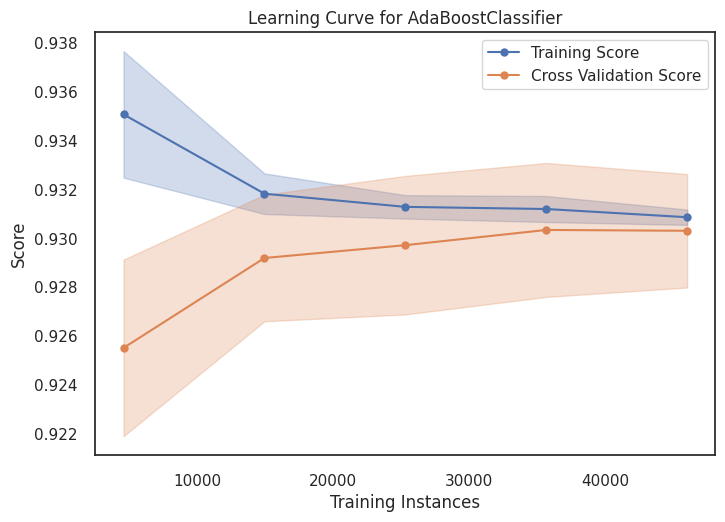

In [57]:
if True:
    # Plot the learning curve
    cv = 10
    visualizer = LearningCurve(estimator=abc, cv=cv, scoring='f1', n_jobs=-1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="abc_data/learning_curve.png")

![Alt text](abc_data/learning_curve.png)

In [61]:
%time pv.cross_validation(ds[x_features], ds.Label, y_res)

Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
CPU times: user 1min 27s, sys: 123 ms, total: 1min 27s
Wall time: 1min 29s


(0.9298996700015216, 0.0021699085334527706, 66.17232728004456)

In [62]:
%time abc.fit(X_train, y_train)

CPU times: user 13.4 s, sys: 7.64 ms, total: 13.4 s
Wall time: 13.4 s


AdaBoostClassifier(n_estimators=64, random_state=0)

In [63]:
%time y_predicted_train = abc.predict(X_train)
%time y_predicted_test = abc.predict(X_test)

CPU times: user 570 ms, sys: 0 ns, total: 570 ms
Wall time: 569 ms
CPU times: user 145 ms, sys: 0 ns, total: 145 ms
Wall time: 145 ms


In [64]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.925865,0.925984
1,PRECISION,0.873213,0.873201
2,RECALL,0.996401,0.996714
3,F1 SCORE,0.930748,0.930878
4,AUC,0.925866,0.925978


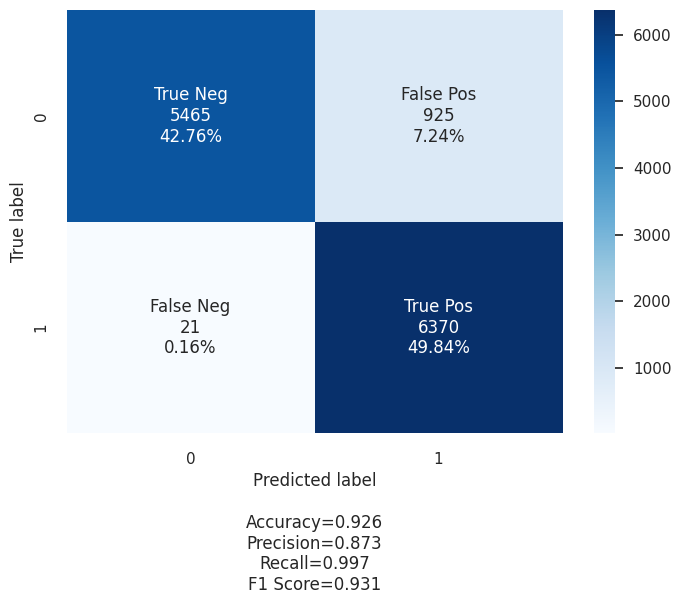

In [65]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [66]:
abc.feature_names_in_

array(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot',
       'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_per_sec',
       'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio',
       'fwd_header_size_tot', 'fwd_header_size_min',
       'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max',
       'flow_FIN_flag_count', 'flow_SYN_flag_count',
       'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count',
       'flow_ACK_flag_count', 'fwd_URG_flag_count', 'bwd_URG_flag_count',
       'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max',
       'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg',
       'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot',
       'bwd_pkts_payload.avg', 'bwd_pkts_payload.std',
       'flow_pkts_payload.min', 'flow_pkts_payload.max',
       'flow_pkts_payload.tot', 'flow_pkts_payload.avg',
       '

In [67]:
feature_importance_dict = dict(zip(x_features, abc.feature_importances_))
important_features = [feature for feature, importance in feature_importance_dict.items() if importance > 0]
pd.DataFrame(data={'features': important_features}).to_csv('abc_data/features_used.csv')

In [68]:
for num, clf in enumerate(abc.estimators_):
    dot_data = tree.export_graphviz(clf, feature_names=x_features, out_file=None, ) 
    graph = graphviz.Source(dot_data)
    graph.render('abc_data/tree/tree_abc_' + str(num))

In [69]:
start_time = time.time()
importances = abc.feature_importances_
std = np.std([tree.feature_importances_ for tree in abc.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.003 seconds


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


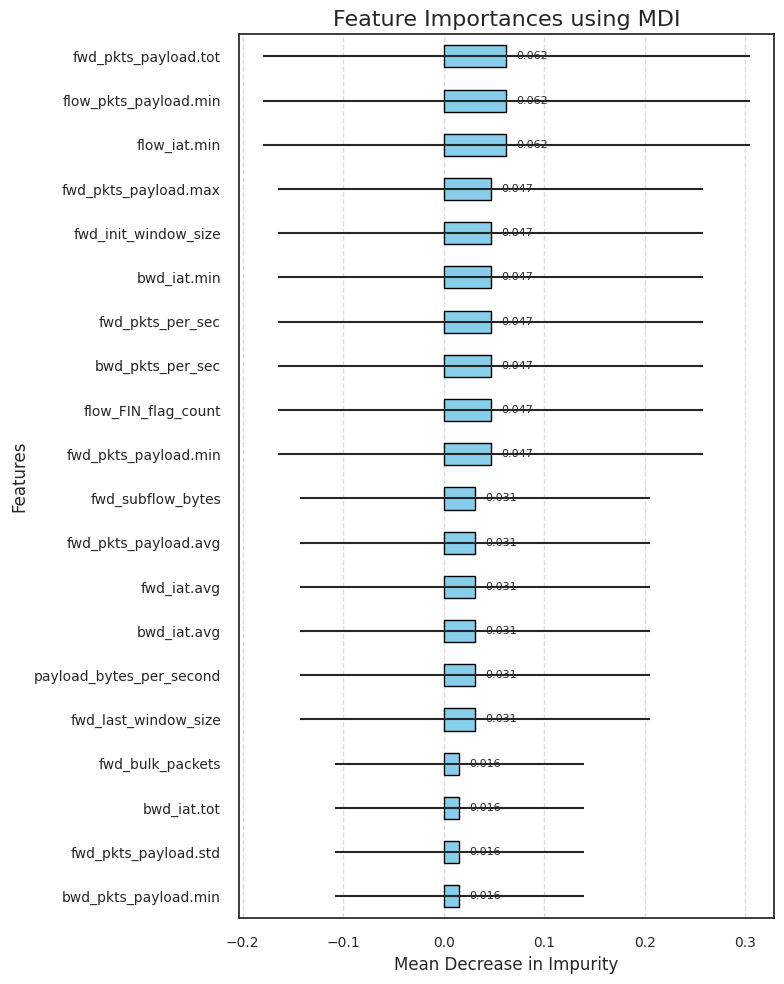

In [70]:
forest_importances = pd.Series(importances, index=x_features)

sorted_indices = np.argsort(forest_importances)[::-1]
sorted_std = std[sorted_indices][:20] # Select only the first 20 features
sorted_importance = forest_importances[sorted_indices][:20]  # Select importance values for the first 20 features

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))  # Adjust the figure size as needed for vertical display

# Create the vertical bar plot with error bars
sorted_importance.plot(kind='barh', xerr=sorted_std, ax=ax, color='skyblue', edgecolor='black')

# Set plot title and labels
ax.set_title("Feature Importances using MDI", fontsize=16)
ax.set_xlabel("Mean Decrease in Impurity", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Invert y-axis to display most important feature at the top
ax.invert_yaxis()

# Add data labels at the end of each bar
for i, v in enumerate(sorted_importance):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

In [71]:
if True:
    print("making exp")
    scaler = StandardScaler()
    scaled_ds = scaler.fit_transform(X_train)

    kmeans = KMeans(n_clusters=1000, random_state=0).fit(scaled_ds)

    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    
    foreground = shap.sample(X_train, 1000)

    explainer = KernelExplainer(abc.predict, centroids)
    sv = explainer.shap_values(foreground)

    exp = Explanation(sv,
                  explainer.expected_value,
                  data=foreground, 
                  feature_names=x_features)

    exp.base_values = np.array([exp.base_values])

    with open('abc_data/exp.pickle', 'wb') as handle:
        pickle.dump(exp, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("loading exp")
    with open('abc_data/exp.pickle', 'rb') as handle:
        exp = pickle.load(handle)

making exp


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  1%|          | 9/1000 [04:56<9:04:05, 32.94s/it] 


KeyboardInterrupt: 

In [28]:
if False:
    scaler = StandardScaler()
    scaled_ds = scaler.fit_transform(ds[x_features])

    kmeans = KMeans(n_clusters=100, random_state=0).fit(scaled_ds)
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)

    exp_list = []

    for k in range(10):
        foreground = shap.sample(X_train, 100)

        explainer = KernelExplainer(abc.predict, centroids)
        sv = explainer.shap_values(foreground)

        exp = Explanation(sv,
                      explainer.expected_value,
                      data=foreground, 
                      feature_names=x_features)

        exp.base_values = np.array([exp.base_values])
        exp_list.append(exp)
        
    with open('abc_data/exp_list.pickle', 'wb') as handle:
        pickle.dump(exp_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("jumping the test")

jumping the test


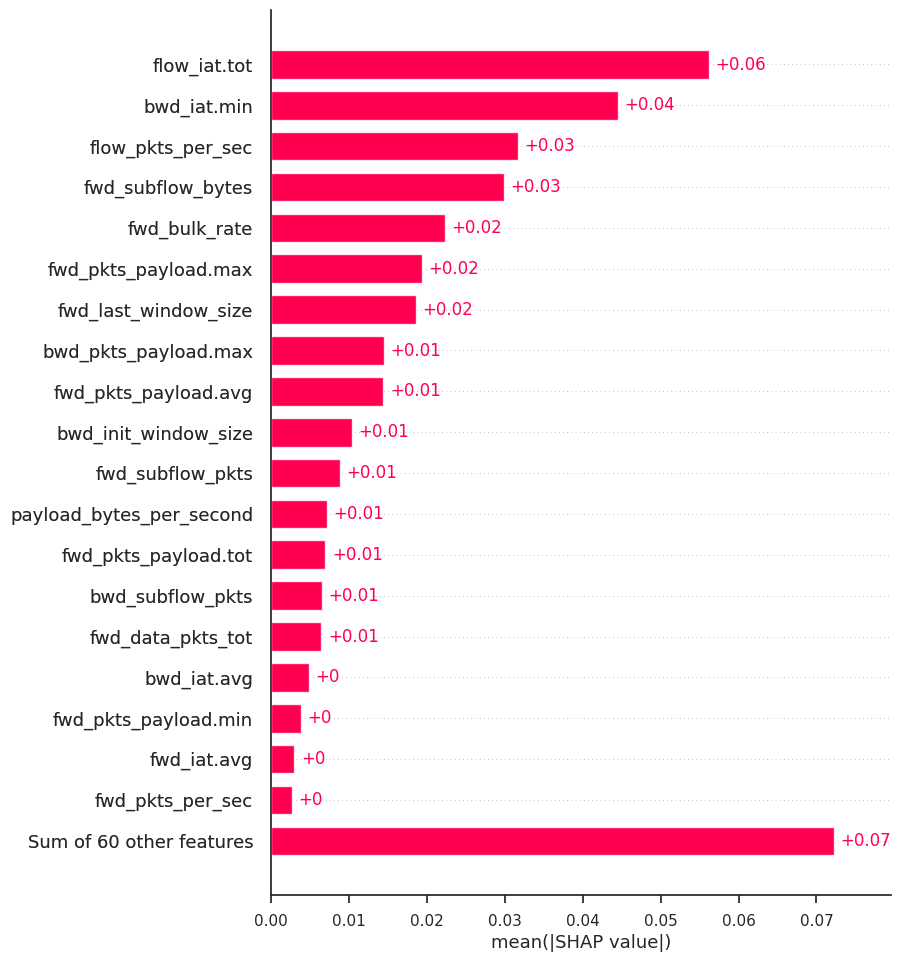

In [32]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

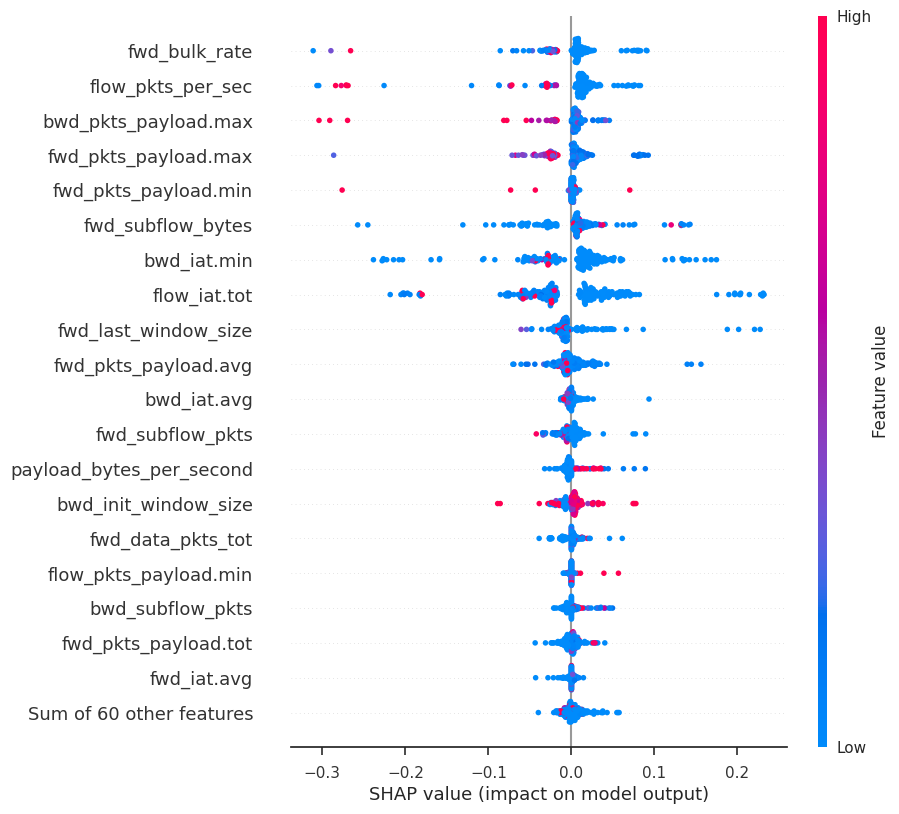

In [33]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

In [34]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
52,0.056179,flow_iat.tot
45,0.044506,bwd_iat.min
7,0.031637,flow_pkts_per_sec
58,0.029869,fwd_subflow_bytes
64,0.022260,fwd_bulk_rate
26,0.019328,fwd_pkts_payload.max
78,0.018531,fwd_last_window_size
31,0.014469,bwd_pkts_payload.max
28,0.014401,fwd_pkts_payload.avg
77,0.010380,bwd_init_window_size


In [35]:
pv.feature_importance.to_csv('abc_data/feature_importance.csv')

In [36]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [ ]:
%%time

if True:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('abc_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('abc_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

<Axes: xlabel='n_features', ylabel='cv_time'>

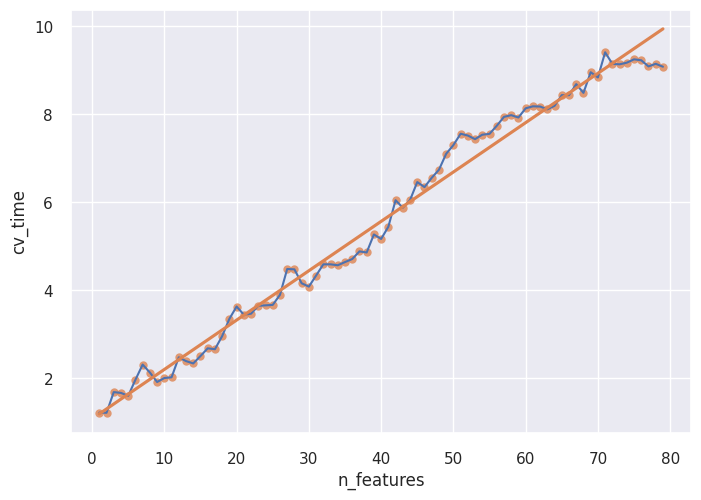

In [39]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

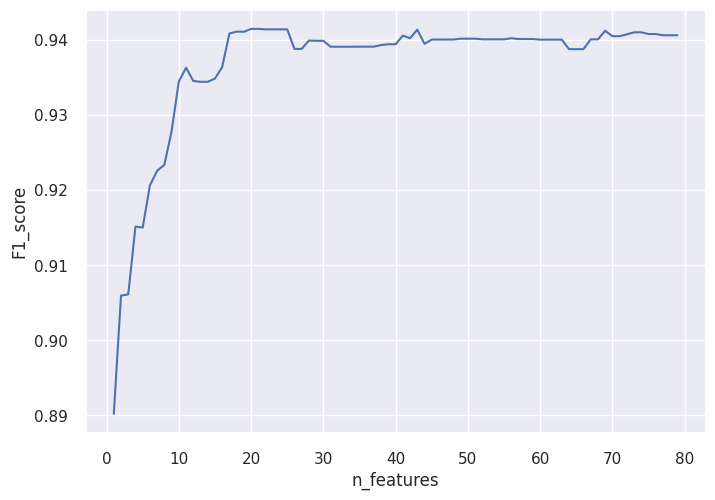

In [40]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

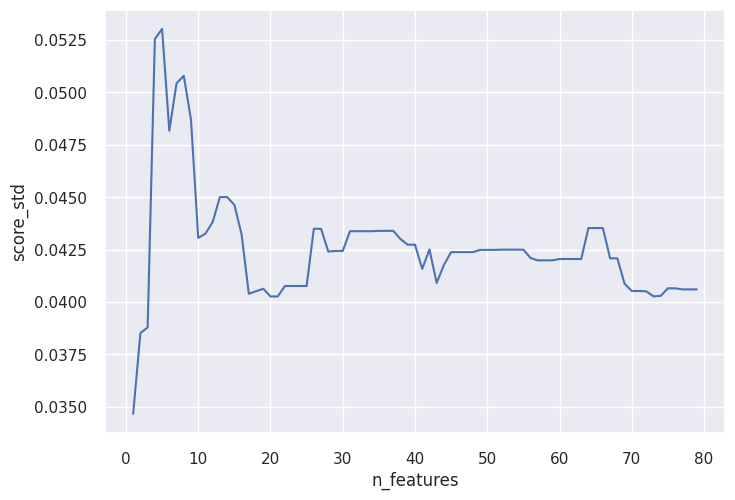

In [41]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [42]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
59,0.941445,0.040262,20,3.631278
58,0.941445,0.040262,21,3.446448
56,0.941382,0.040760,23,3.647725
55,0.941382,0.040760,24,3.658164
54,0.941382,0.040760,25,3.668159
...,...,...,...,...
75,0.915129,0.052549,4,1.668685
74,0.914999,0.053036,5,1.602927
76,0.906110,0.038778,3,1.686728
77,0.905944,0.038515,2,1.217764


In [ ]:
%%time

if True:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('abc_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('abc_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

In [45]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [46]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
78,0.892123,0.972248,0.824199,0.898577,0.031155,1,XMRIGCC CryptoMiner,0.261796,0.021043,1
236,0.847453,0.880146,0.817101,0.895972,0.032803,1,Bruteforce,0.252506,0.024139,1
235,0.850314,0.867948,0.833382,0.907081,0.037130,2,Bruteforce,0.274462,0.019921,1
234,0.846545,0.863068,0.830643,0.908770,0.036375,3,Bruteforce,0.371499,0.023779,1
315,0.667348,0.597133,0.756277,0.900919,0.031164,1,Bruteforce-XML,0.244667,0.022074,1
...,...,...,...,...,...,...,...,...,...,...
82,0.000591,0.000305,0.009434,0.980710,0.002153,76,Probing,2.905994,0.046098,1
137,0.000592,0.000305,0.010000,0.979904,0.003102,21,Probing,0.831663,0.026858,1
138,0.000592,0.000305,0.010000,0.979904,0.003102,20,Probing,0.888886,0.024114,1
139,0.000592,0.000305,0.010000,0.980002,0.003065,19,Probing,0.789184,0.022612,1


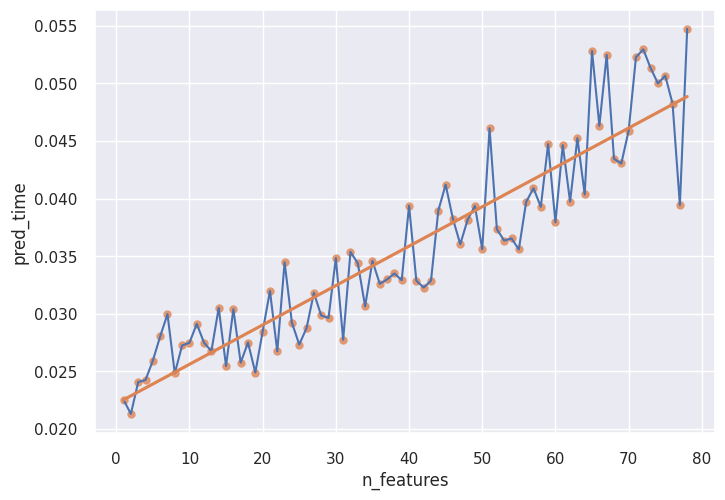

In [47]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

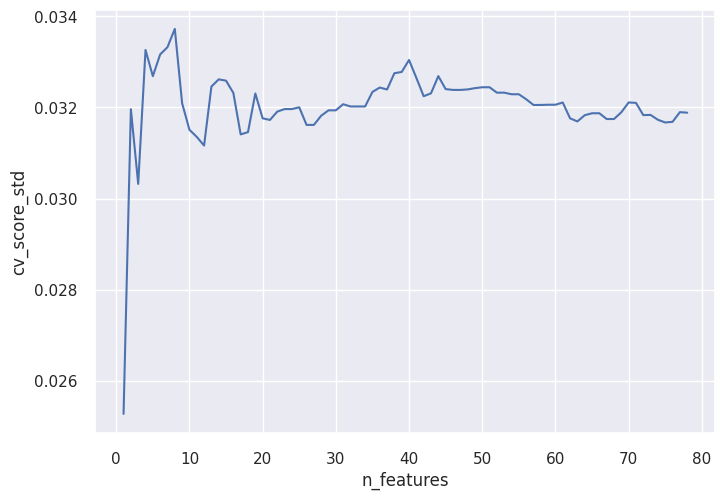

In [48]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [49]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
1,0.628443,0.627783,0.699992,0.909839,0.025274,0.246438,0.022536,1.00
3,0.399951,0.369244,0.516875,0.923652,0.030322,0.381254,0.024082,0.75
2,0.390800,0.358417,0.512347,0.920751,0.031962,0.280948,0.021322,0.75
4,0.157847,0.120311,0.258606,0.934808,0.033262,0.432737,0.024263,0.50
5,0.157987,0.120235,0.258716,0.935560,0.032687,0.431432,0.025939,0.50
...,...,...,...,...,...,...,...,...
51,0.001093,0.000610,0.005263,0.953144,0.032443,2.171942,0.046113,0.25
45,0.000957,0.000534,0.004605,0.953079,0.032403,1.810688,0.041209,0.25
46,0.000957,0.000534,0.004605,0.952969,0.032385,1.855354,0.038229,0.25


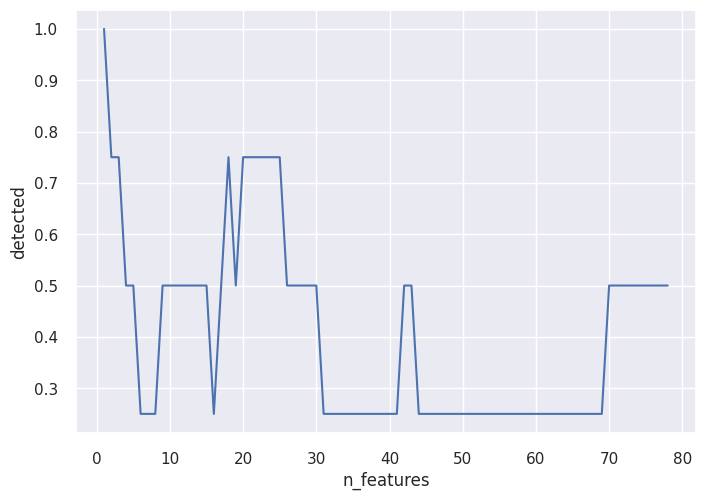

In [50]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

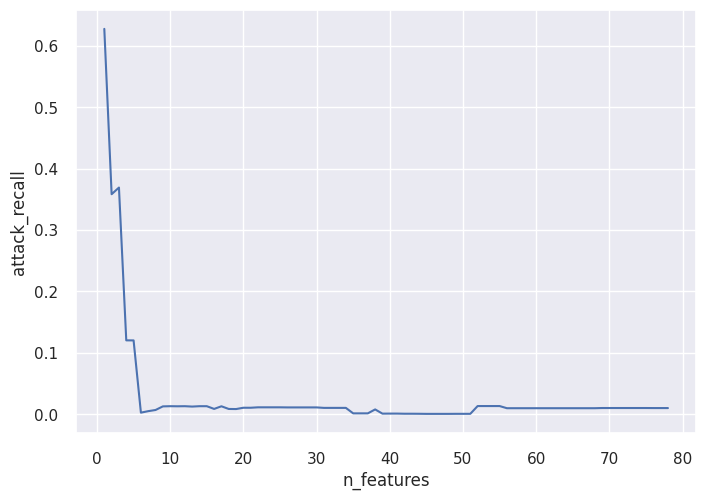

In [51]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [52]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
1,0.628443,0.627783,0.699992,0.909839,0.025274,0.246438,0.022536
3,0.399951,0.369244,0.516875,0.923652,0.030322,0.381254,0.024082
2,0.390800,0.358417,0.512347,0.920751,0.031962,0.280948,0.021322
5,0.157987,0.120235,0.258716,0.935560,0.032687,0.431432,0.025939
4,0.157847,0.120311,0.258606,0.934808,0.033262,0.432737,0.024263
...,...,...,...,...,...,...,...
49,0.001093,0.000610,0.005263,0.953039,0.032423,2.014369,0.039364
45,0.000957,0.000534,0.004605,0.953079,0.032403,1.810688,0.041209
48,0.000957,0.000534,0.004605,0.953199,0.032395,1.964228,0.038163


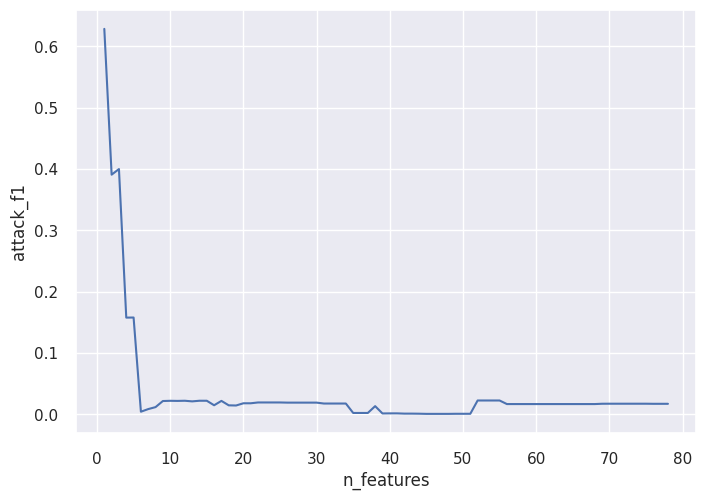

In [53]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [54]:
zero_day_feature_reduction_scores.query('n_features == 1')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
78,0.892123,0.972248,0.824199,0.898577,0.031155,1,XMRIGCC CryptoMiner,0.261796,0.021043,1
157,0.106850,0.061604,0.402390,0.943886,0.005973,1,Probing,0.226782,0.022890,1
236,0.847453,0.880146,0.817101,0.895972,0.032803,1,Bruteforce,0.252506,0.024139,1
315,0.667348,0.597133,0.756277,0.900919,0.031164,1,Bruteforce-XML,0.244667,0.022074,1


In [55]:
zero_day_feature_reduction_scores.query('n_features == 79')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
0,0.000000,0.000000,0.000000,0.945038,0.048100,79,XMRIGCC CryptoMiner,3.401322,0.042325,0
79,0.000591,0.000305,0.009434,0.980096,0.003001,79,Probing,3.118168,0.043558,1
158,0.068856,0.039646,0.261569,0.946241,0.039306,79,Bruteforce,2.597898,0.038903,1
237,0.000000,0.000000,0.000000,0.941795,0.037134,79,Bruteforce-XML,2.934618,0.042022,0
